In [1]:
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import os

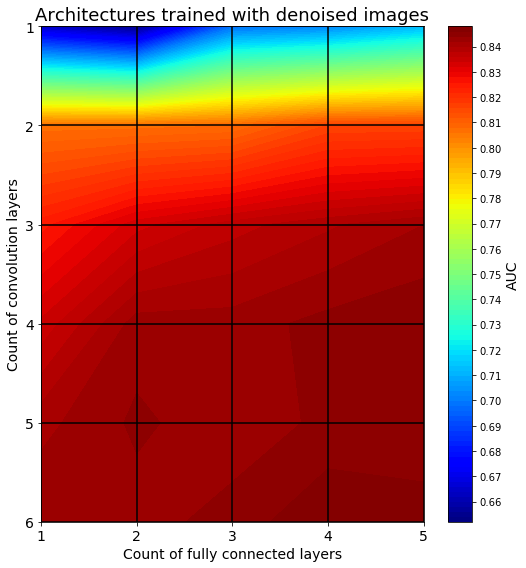

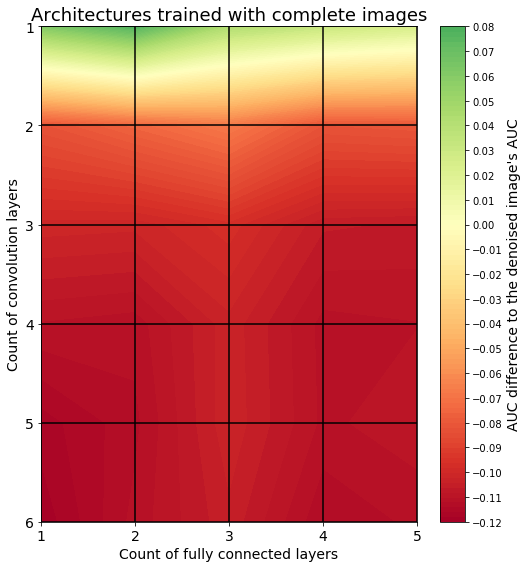

In [2]:
main_path = '/fhgfs/users/jbehnken/make_Data/architectures'
folders = [os.path.join(main_path, folder) for folder in os.listdir(main_path)]
titles = ['Compare_diffuse_flat_architectures', 'Compare_architectures']
path_build = '/home/jbehnken/07_make_FACT/build/'

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


heatmaps = []
for title in titles:
        
    heatmap_data = []
    for folder in folders:
        architecture =  folder.split('_')[-1]
        df = pd.read_csv(os.path.join(folder, architecture+'_Hyperparameter.csv'))
        heatmap_data.append([title, architecture, df[df['Title']==title].sort_values(by='Auc', ascending=False).head(10)['Auc'].mean()])
    heatmaps.append(heatmap_data)

matrices = []
for heatmap_data in heatmaps:
    matrix = np.ones((6, 5))
    for arch in heatmap_data:
        c = arch[1].count('c')-1
        f = arch[1].count('f')-1
        matrix[c, f] = arch[2]
    matrices.append(matrix)

font_big = 18
font_small = 14

plt.figure(figsize=(7.5,8))
plt.contourf(matrices[0], 100, cmap='jet')
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.set_ticks(np.arange(0.0, 1.0, 0.01), update_ticks=True)
cbar.ax.set_ylabel('AUC', fontsize=font_small)

plt.yticks(range(6), range(1,7), fontsize=font_small)
plt.xticks(range(5), range(1,6), fontsize=font_small)

plt.title('Architectures trained with denoised images', fontsize=font_big)
plt.xlabel('Count of fully connected layers', fontsize=font_small)
plt.ylabel('Count of convolution layers', fontsize=font_small)

for i in range(6):
    plt.plot([0,4], [i, i], 'k')
for i in range(5):
    plt.plot([i,i], [0, 5], 'k')

plt.tight_layout()
plt.savefig(path_build+'Architectures_AUC_denoised.pdf')
plt.show()


elev_min = -0.12
elev_max = 0.12

plt.figure(figsize=(7.5,8))
plt.contourf(matrix[1]-matrices[0], 100, cmap='RdYlGn', clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=0,vmin=elev_min, vmax=elev_max))
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.set_ticks(np.arange(elev_min, elev_max, 0.01), update_ticks=True)
cbar.ax.set_ylabel("AUC difference to the denoised image's AUC", fontsize=font_small)

plt.yticks(range(6), range(1,7), fontsize=font_small)
plt.xticks(range(5), range(1,6), fontsize=font_small)

plt.title('Architectures trained with complete images', fontsize=font_big)
plt.xlabel('Count of fully connected layers', fontsize=font_small)
plt.ylabel('Count of convolution layers', fontsize=font_small)

for i in range(6):
    plt.plot([0,4], [i, i], 'k')
for i in range(5):
    plt.plot([i,i], [0, 5], 'k')

plt.tight_layout()
plt.savefig(path_build+'Architectures_AUC_noised.pdf')
plt.show()

In [5]:
time = []
for folder in folders:
    architecture =  folder.split('_')[-1]
    
    df = pd.read_csv(os.path.join(folder, architecture+'_Hyperparameter.csv'))
    time.append([architecture, df[df['Title']==titles[0]]['Time'].values])

np_time = []
for arch in time:
    np_time.extend(arch[1])
    if len(arch[1])!=50:
        print(arch[0], len(arch[1]), np.mean(arch[1]))
np_time = np.array(np_time)

print('\nMean: {}\nStd: {}'.format(np.mean(np_time), np.std(np_time)))

t = np.mean(np_time)*(1500-len(np_time))/3600
h = int(t)
m = int(60*(t%1))
s = int(round(60*((60*(t%1))%1)))

print('\nRestdauer: {}h {}m {}s'.format(h, m, s))


Mean: 246.41608617194493
Std: 677.4750260910282

Restdauer: 0h 0m 0s


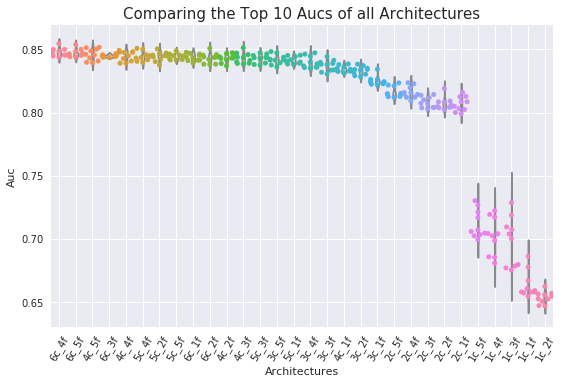

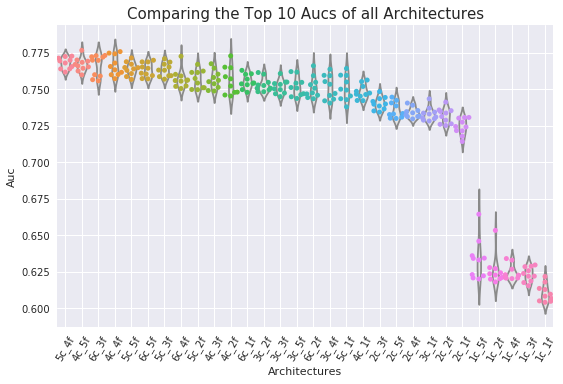

In [6]:
import seaborn as sns

for title in titles:
    comparison_names = []
    comparison_auc = []
    for folder in folders:
        architecture =  folder.split('_')[-1]
        c = architecture.count('c')
        f = architecture.count('f')

        name_new = str(c)+'c_'+str(f)+'f'
        comparison_names.append(name_new)


        df = pd.read_csv(os.path.join(folder, architecture+'_Hyperparameter.csv'))
        comparison_auc.append(df[df['Title']==title].sort_values(by='Auc', ascending=False).head(10)['Auc'].values.tolist())
        
        
    df_plot = pd.DataFrame(np.array(comparison_auc).T, columns=comparison_names)
    df_plot = df_plot[df_plot.mean().sort_values(ascending=False).index]

    df_swarm = pd.melt(df_plot)
    df_swarm.columns = ['Architectures', 'Auc']
    sns.set(style='darkgrid', font='DejaVu Sans')
    plt.title('Comparing the Top 10 Aucs of all Architectures', fontsize=15)
    sns.violinplot(x="Architectures", y="Auc", data=df_swarm, inner=None, color=".9")
    sns.swarmplot(x="Architectures", y="Auc", data=df_swarm)
    plt.xticks(rotation=60)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

In [7]:
for part in df_plot.columns[0].split('_'):
    if 'c' in part:
        c = int(part[0])
    if 'f' in part:
        f = int(part[0])
name = '_'+'c'*c + 'f'*f

for folder in folders:
    if folder.endswith(name):
        loading_path = folder +'/'+name[1:]+'_Hyperparameter.csv'
        
df = pd.read_csv(loading_path)
df.tail()

,Learning_Rate,Batch_Size,Patch_Size,Depth_1,Depth_2,Depth_3,Depth_4,Depth_5,Hidden_Nodes,Accuracy,Auc,Steps,Early_Stopped,Time,Title
95,0.001,182,3,16,33,50,53,67,84,66.66,0.729559,7200,True,271.846383,Compare_diffuse_flat_architectures
96,0.001,187,5,17,24,35,46,66,171,75.88,0.843261,10000,True,414.845143,Compare_diffuse_flat_architectures
97,0.001,236,5,7,11,16,34,36,164,68.94,0.770730,11500,True,398.137864,Compare_diffuse_flat_architectures
98,0.001,181,3,16,25,28,44,58,172,74.95,0.837975,8600,True,302.794604,Compare_diffuse_flat_architectures
99,0.001,116,5,11,25,44,51,58,126,75.37,0.840553,8500,True,286.553082,Compare_diffuse_flat_architectures


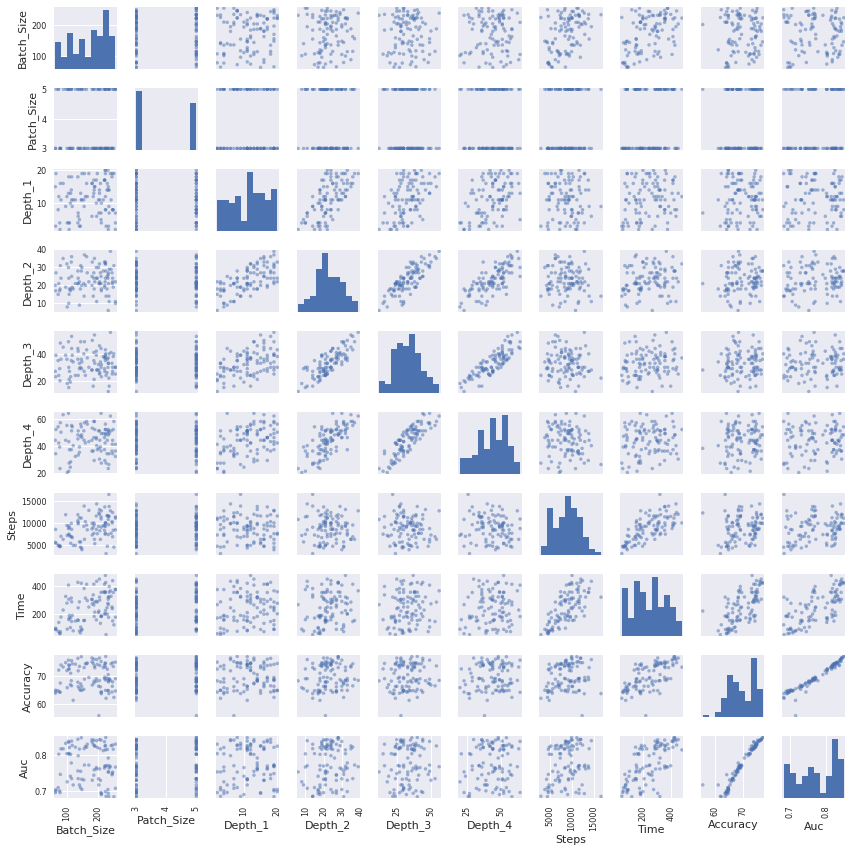

In [8]:
pd.plotting.scatter_matrix(df[df['Auc']>0.68][['Batch_Size', 'Patch_Size', 'Depth_1', 'Depth_2', 'Depth_3', 'Depth_4', 'Steps', 'Time', 'Accuracy', 'Auc']], figsize=(12,12))
plt.tight_layout()
plt.show()

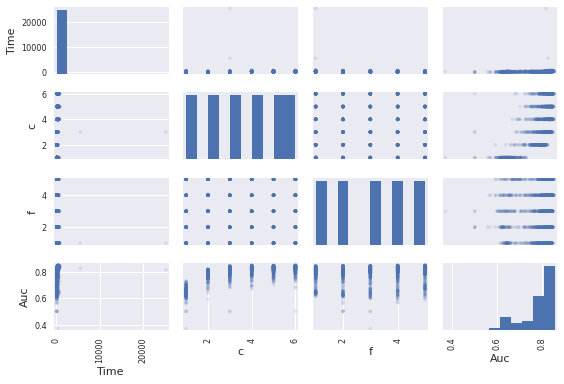

In [9]:
dfs = []
for folder in folders:
    name = folder.split('_')[-1]
    loading_path = folder+'/'+name+'_Hyperparameter.csv'
    c = name.count('c')
    f = name.count('f')
    df = pd.read_csv(loading_path)
    df['c'] = c
    df['f'] = f
    df = df[df['Title']==titles[0]][['Time', 'c', 'f', 'Auc']]
    dfs.append(df)
    
df = pd.concat(dfs)

pd.plotting.scatter_matrix(df, alpha=0.15)
plt.tight_layout()
plt.show()

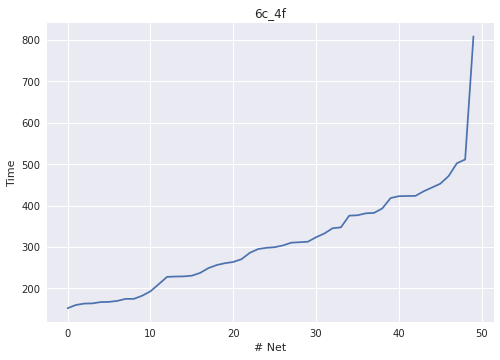

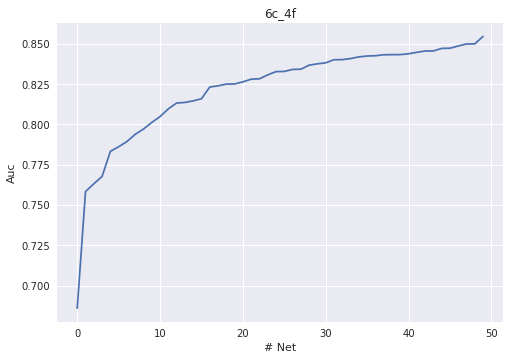

In [10]:
c = 6
f = 4

for column in ['Time', 'Auc']:
    for df in dfs:
        if c in df['c'].values and df['c'].values[0]==c and df['f'].values[0]==f:
            use = df

    plt.plot(use.sort_values(by=column)[column].values)
    plt.title('{}c_{}f'.format(c, f))
    plt.xlabel('# Net')
    plt.ylabel(column)
    plt.show()

In [11]:
time = []
for df in dfs:
    time.extend(df['Time'].values)
np.sum(time)/60/60

102.6733692383104

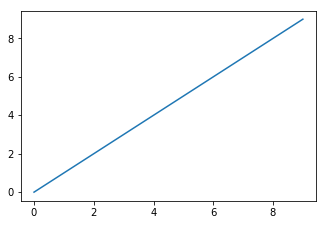

In [17]:
plt.figure(figsize=(5.3,3.5))
plt.plot(range(10))
plt.show()